In [2]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
import numpy as np

In [6]:
import sys
sys.path.insert(0, '../')
from libra import trappist1_all_transits

Remove transits, mask flares, median filter

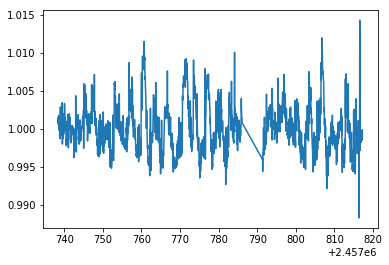

In [20]:
from astropy.io import fits
from scipy.signal import medfilt

f = fits.getdata('../libra/data/trappist1/nPLDTrappist.fits')
k2_flux, k2_time = f['FLUX'], f['TIME']

k2_flux /= np.nanmedian(k2_flux)
mask = (k2_flux > 0.9) & (k2_flux < 1.5)
k2_flux = k2_flux[mask]
k2_time = k2_time[mask] + 2454833

p = np.polyfit(k2_time - k2_time.mean(), k2_flux, 10)
k2_flux -= np.polyval(p, k2_time - k2_time.mean()) - 1

k2_flux = medfilt(k2_flux, (3, ))

model = trappist1_all_transits(k2_time)[:, 0]

mask = (k2_flux < 1.01)

k2_time = k2_time[mask]
k2_flux = (k2_flux/model)[mask]

plt.plot(k2_time, k2_flux)


#plt.ylim([0.99, 1.01])

In [22]:
k2_flux_1 = k2_flux[k2_time < 2457788]
k2_time_1 = k2_time[k2_time < 2457788]

k2_flux_2 = k2_flux[k2_time > 2457788]
k2_time_2 = k2_time[k2_time > 2457788]

Chop up light curve at the data gap, use the longer chunk for this analysis:

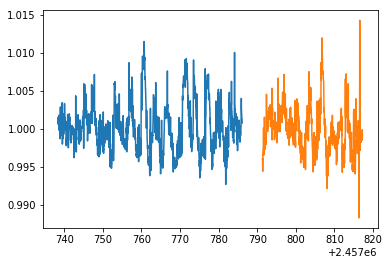

In [24]:
plt.plot(k2_time_1, k2_flux_1)
plt.plot(k2_time_2, k2_flux_2)

In [25]:
from interpacf import interpolated_acf

In [54]:
lag_1, acf_1 = interpolated_acf(k2_time_1, k2_flux_1 - np.median(k2_flux_1))

acf = acf_1[lag_1 < 3]
lag = lag_1[lag_1 < 3]

In [94]:
def manual_kernel(p, lag):
    a, c, per, a2, c2, offset = p
    return a * np.exp(-c * lag) * np.cos(2*np.pi/per * lag) + a2 * np.exp(-c2 * lag) + offset

from scipy.optimize import fmin_l_bfgs_b

def chi2(p):
    return np.sum((manual_kernel(p, lag) - acf)**2)

bounds = [[0, 1], [0, 10], [2, 4], [0, 1], [10, 1000], [-1, 1]]
initp = [0.02, 0.55, 3.3, 0.0015, 50, 0]
result = fmin_l_bfgs_b(chi2, initp, approx_grad=True)

plt.plot(lag, acf)
#plt.plot(lag, manual_kernel(initp, lag))
plt.plot(lag, manual_kernel(result[0], lag))

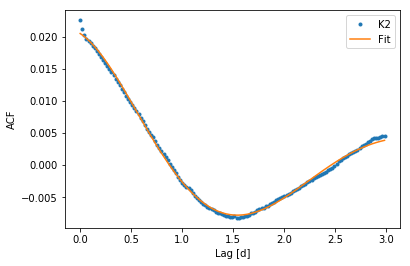

In [107]:
# def manual_kernel(p, lag):
#     a, c, per, offset = p
#     return a * np.exp(-c * lag) * np.cos(2*np.pi/per * lag) + offset

# from scipy.optimize import fmin_l_bfgs_b

# def chi2(p):
#     return np.sum((manual_kernel(p, lag) - acf)**2)

# bounds = [[0, 1], [0, 10], [2, 4], [-1, 1]]
# initp = [0.02, 0.55, 3.3, 0]
# result = fmin_l_bfgs_b(chi2, initp, approx_grad=True)

# plt.plot(lag, acf, '.', label='K2')
# #plt.plot(lag, manual_kernel(initp, lag))
# plt.plot(lag, manual_kernel(result[0], lag), label='Fit')
# plt.ylabel('ACF')
# plt.xlabel('Lag [d]')
# plt.legend()

Fit the residuals after removing starspot modulation:

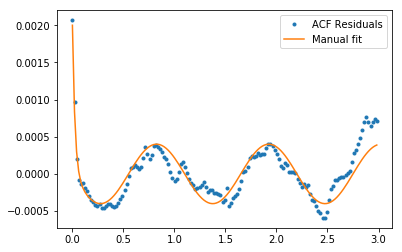

In [112]:
plt.plot(lag, acf - manual_kernel(result[0], lag), '.', label='ACF Residuals')
amp = 0.0004
period = 1.1
c = 40
plt.plot(lag, 0.002 * np.exp(-c*lag) - amp*np.sin(2*np.pi/period*lag), label='Manual fit')
plt.legend()